In [4]:
import pickle
import matplotlib.pyplot as plt
import datetime 
import numpy as np
import pandas as pd
from functools import reduce
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
custom_colors = ["#4e89ae", "#c56183","#ed6663","#ffa372"]


### Import the dataset

In [5]:
df=pd.read_json('/crypto.json', lines=True)
print(df.shape)

(1909, 26)


There are 1,909 rows and 29 columns.
It is a medium size dataset with a medium number of rows and a medium number of columns.

In [6]:
!pip install colorama

In [9]:
#Colorama
from colorama import Fore, Back, Style # For text colors
y_= Fore.GREEN
#y_= Fore.CYAN
m_= Fore.WHITE

In [10]:
print(f"{m_}Total records:{y_}{df.shape}\n")
print(f"{m_}Data types of data columns: \n{y_}{df.dtypes}")

Total records:(1909, 26)

Data types of data columns: 
id                                          object
symbol                                      object
name                                        object
date                                datetime64[ns]
current_price                              float64
market_cap                                 float64
total_volume                               float64
alexa_rank                                   int64
bing_matches                               float64
pull_request_contributors                  float64
commit_count_4_weeks                       float64
pull_requests_merged                       float64
closed_issues                              float64
stars                                      float64
total_issues                               float64
code_additions_deletions_4_weeks            object
subscribers                                float64
forks                                      float64
small                      

There are int64, object, and float64 dtypes in features of our dataset.
Generally, object dtype is used for Categorical Variables.
int64 and float64 dtypes are used for Numerical Variables.


### Variable Definition

id: name of crypto

current_price:price of the cryptocurrency

market_cap: is the total value of all the coins that have been mined. It's calculated by multiplying the number of coins in circulation by the current market price of a single coin.

total_volume: Total cryptocurrency trading volume in the last day

alexa_rank: Alexa rank is a measure of website popularity. It ranks millions of websites in order of popularity, with an Alexa Rank of 1 being the most popular. Alexa Rank reveals how a website is doing relative to all other sites, which makes it a great KPI for benchmarking and competitive analysis

bing_matches Add provided by Microsoft. Stopped in 2018

stars

pull_request, pull_request_contributors,commit_count_4_weeks, pull_requests_merged, closed_issues, total_issues,code_additions_deletions_4_weeks, and forks: Ussually are proposed changes to the code or documentation in the source code repository

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909 entries, 0 to 1908
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1909 non-null   object        
 1   symbol                            1909 non-null   object        
 2   name                              1909 non-null   object        
 3   date                              1909 non-null   datetime64[ns]
 4   current_price                     1909 non-null   float64       
 5   market_cap                        1908 non-null   float64       
 6   total_volume                      1909 non-null   float64       
 7   alexa_rank                        1909 non-null   int64         
 8   bing_matches                      0 non-null      float64       
 9   pull_request_contributors         1788 non-null   float64       
 10  commit_count_4_weeks              1763 non-null 

There are 18 features as *float64* dtype, 1 feature as *int64* dtype, 1 feature as *datetime*, and 6 features as *object* dtype.

The **bing_matches** and **facebook_likes** features has 0 non-null values out of 1,909.

The **pull_request_contributors**  and **pull_requests_merged** features has 1,788 non-null values out of 1,909.

The **commit_count_4_weeks** feature has 1,763 non-null values out of 1,909.

The **closed_issues**, **stars**, **total_issues**, **subscribers** and **forks** features has 1,769 non-null values out of 1,909.

The **reddit_accounts_active_48h** and **reddit_subscribers** features has 1,897 non-null values out of 1,909.

The **twitter_followers** feature has 1,840 non-null values out of 1,909.

The range of the Index is 1,909 entries, which is 0 to 1,908.
The total number of data columns is 26.

### Basic information 

In [12]:
df.describe()

,current_price,market_cap,total_volume,alexa_rank,bing_matches,pull_request_contributors,commit_count_4_weeks,pull_requests_merged,closed_issues,stars,total_issues,subscribers,forks,reddit_accounts_active_48h,reddit_average_comments_48h,reddit_subscribers,reddit_average_posts_48h,twitter_followers,facebook_likes
count,1909.000000,1.908000e+03,1.909000e+03,1909.000000,0.0,1788.000000,1763.000000,1788.000000,1769.000000,1769.000000,1769.000000,1769.000000,1769.000000,1897.000000,1909.000000,1.897000e+03,1909.000000,1.840000e+03,0.0
mean,16599.862578,3.057727e+11,2.058751e+10,9722.027763,NaN,584.077181,259.532048,6645.268456,3524.305257,37331.535896,4000.771057,3169.717920,21578.332956,6481.092742,487.742344,1.471329e+06,4.877114,7.075110e+05,NaN
std,17431.500617,3.304798e+11,2.019060e+10,3951.574425,NaN,117.698075,73.856308,1522.006368,1894.950440,13801.283869,2087.233168,796.126906,7098.101846,3870.246837,437.885956,1.064996e+06,2.090997,1.317022e+06,NaN
min,784.277500,1.262408e+10,2.028832e+07,2692.000000,NaN,378.000000,91.000000,4099.000000,0.000000,10874.000000,0.000000,1290.000000,7124.000000,393.000000,0.000000,1.984680e+05,0.000000,5.123600e+04,NaN
25%,5841.053771,1.006494e+11,2.953789e+09,6058.000000,NaN,482.000000,206.000000,5276.250000,2673.000000,30578.000000,3156.000000,3206.000000,18343.000000,3891.461538,210.957000,8.160220e+05,2.478000,6.826400e+04,NaN
50%,8878.428260,1.581698e+11,1.890459e+10,9893.000000,NaN,589.000000,256.000000,6558.000000,3605.000000,39406.000000,4159.000000,3507.000000,23707.000000,5228.833333,284.435000,1.115562e+06,4.652000,7.326450e+04,NaN
75%,18807.095403,3.469306e+11,3.142360e+10,12740.000000,NaN,691.000000,303.000000,7932.750000,5183.000000,45455.000000,5745.000000,3572.000000,26437.000000,9078.000000,675.208000,1.797090e+06,6.750000,3.491368e+05,NaN
max,67617.015545,1.278798e+12,1.788941e+11,18724.000000,NaN,773.000000,470.000000,9548.000000,6182.000000,62765.000000,6794.000000,3907.000000,31890.000000,26336.000000,3647.545000,4.026841e+06,9.500000,4.863826e+06,NaN


### For each numerical feature compute number of unique entries


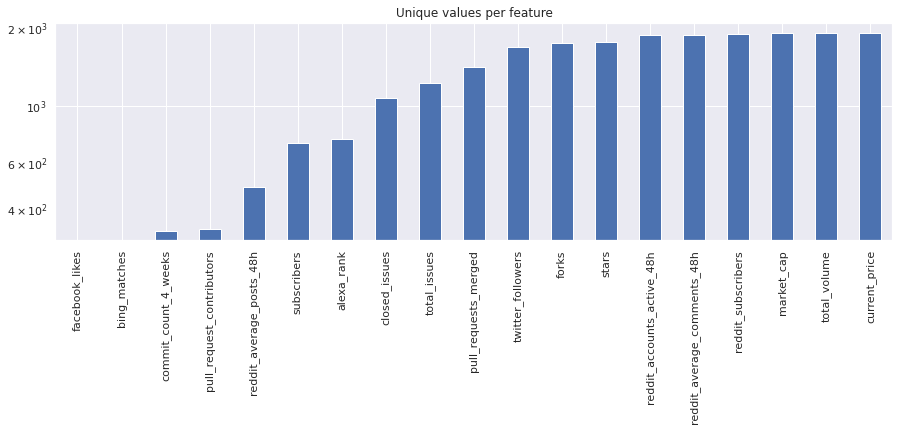

In [227]:
unique_values = df.select_dtypes(
  include="number").nunique().sort_values()

# Plot information with y-axis in log-scale
unique_values.plot.bar(logy=True, figsize=(15, 4),
                       title="Unique values per feature");

The **current_price**, **market_cap** and **total_volume** features has the most unique values


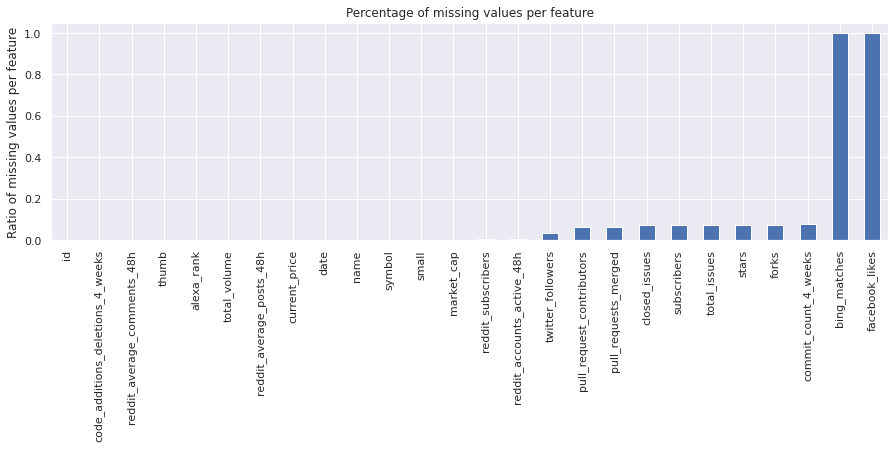

In [13]:
df.isna().mean().sort_values().plot(
    kind="bar", figsize=(15, 4),
    title="Percentage of missing values per feature",
    ylabel="Ratio of missing values per feature");

**bing_matches** and **facebook_likes** are made up of null values 

### Summary of variables with null values


In [14]:
df.isnull().sum()

id                                     0
symbol                                 0
name                                   0
date                                   0
current_price                          0
market_cap                             1
total_volume                           0
alexa_rank                             0
bing_matches                        1909
pull_request_contributors            121
commit_count_4_weeks                 146
pull_requests_merged                 121
closed_issues                        140
stars                                140
total_issues                         140
code_additions_deletions_4_weeks       0
subscribers                          140
forks                                140
small                                  0
thumb                                  0
reddit_accounts_active_48h            12
reddit_average_comments_48h            0
reddit_subscribers                    12
reddit_average_posts_48h               0
twitter_follower

The **current_price**, **total_volume**, **alexa_rank**, **code_additions_deletions_4_weeks**, **smal**l and **thumb** features has cero null values


Looking for missing values in a heatmap

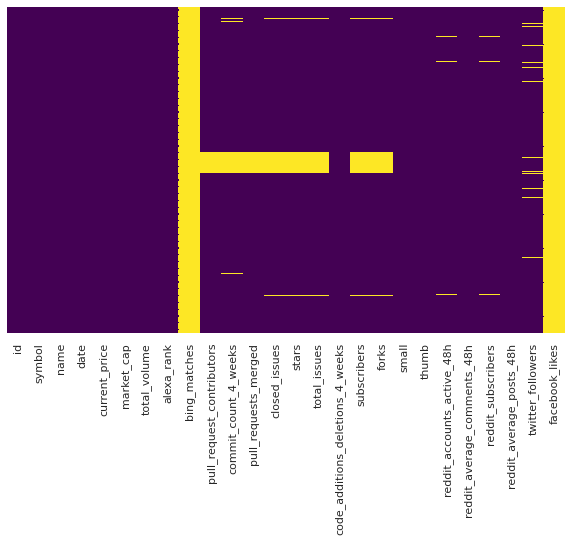

In [236]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

Get rid of the **bing_marches** and the **facebook_likes** features


In [237]:
# Get rid of the bing_marches and the facebook_likes variables
df.drop('bing_matches', axis=1, inplace=True)
df.drop('facebook_likes', axis=1, inplace=True)

Assign the average value to all NaN´s

In [240]:
df.loc[df.pull_request_contributors.isnull(), 'pull_request_contributors'] = df[~df.pull_request_contributors.isnull()].pull_request_contributors.mean()
df.loc[df.commit_count_4_weeks.isnull(), 'commit_count_4_weeks'] = df[~df.commit_count_4_weeks.isnull()].commit_count_4_weeks.mean()
df.loc[df.pull_requests_merged.isnull(), 'pull_requests_merged'] = df[~df.pull_requests_merged.isnull()].pull_requests_merged.mean()
df.loc[df.closed_issues.isnull(), 'closed_issues'] = df[~df.closed_issues.isnull()].closed_issues.mean()
df.loc[df.stars.isnull(), 'stars'] = df[~df.stars.isnull()].stars.mean()
df.loc[df.total_issues.isnull(), 'total_issues'] = df[~df.total_issues.isnull()].total_issues.mean()
df.loc[df.subscribers.isnull(), 'subscribers'] = df[~df.subscribers.isnull()].subscribers.mean()
df.loc[df.forks.isnull(), 'forks'] = df[~df.forks.isnull()].forks.mean()
df.loc[df.reddit_accounts_active_48h.isnull(), 'reddit_accounts_active_48h'] = df[~df.reddit_accounts_active_48h.isnull()].reddit_accounts_active_48h.mean()
df.loc[df.reddit_subscribers.isnull(), 'reddit_subscribers'] = df[~df.reddit_subscribers.isnull()].reddit_subscribers.mean()
df.loc[df.twitter_followers.isnull(), 'twitter_followers'] = df[~df.twitter_followers.isnull()].twitter_followers.mean()
df.loc[df.market_cap.isnull(), 'market_cap'] = df[~df.market_cap.isnull()].market_cap.mean()




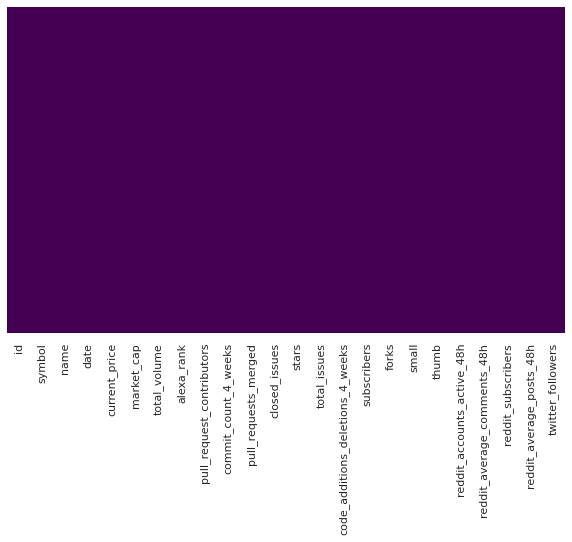

In [241]:
# Look again for missing values (null and/or NaN)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

For numeric features, we want to know the range of values present and how often these values (or groups of values) occur.


For categorical features, we want to know the number of unique classes and how frequently they occur.


In [186]:
print(f"{m_}Average current_price: {df[~df.current_price.isnull()].current_price.mean():.1f}")


Average current_price: 16599.9


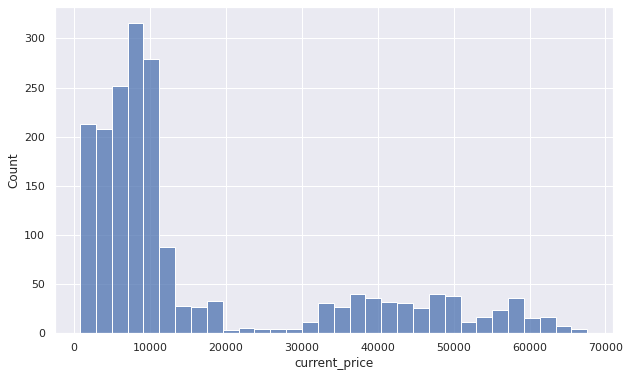

In [187]:
sns.histplot(x='current_price', data=df)


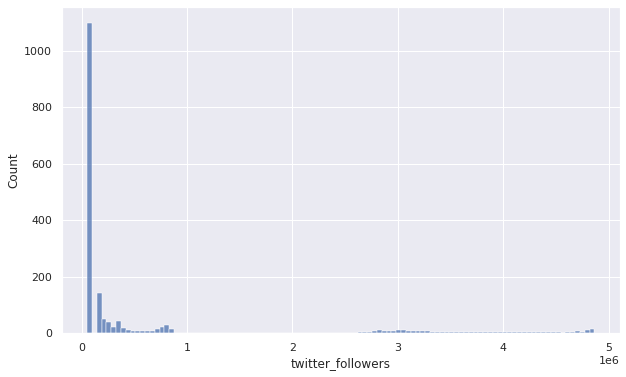

In [254]:
sns.histplot(x='twitter_followers', data=df)


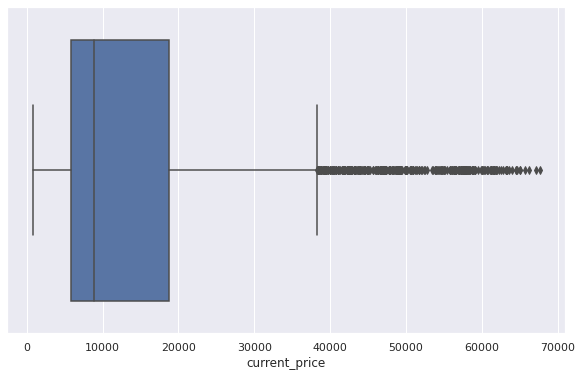

In [188]:
sns.boxplot(x=df['current_price'])


In the box plot, we can see that the right whisker has a near 40,000 current_price value.

We can see the positions of outliers

In [197]:
#np.where(df['current_price']>40000)

(array([   9,   12,   24,   29,   48,   51,   52,   76,   78,  105,  121,
         129,  134,  136,  161,  164,  172,  177,  182,  195,  197,  202,
         209,  211,  221,  226,  238,  249,  250,  260,  264,  290,  293,
         314,  316,  318,  351,  367,  371,  378,  383,  385,  406,  426,
         428,  429,  431,  441,  447,  451,  455,  458,  477,  485,  488,
         502,  508,  512,  529,  553,  563,  568,  572,  574,  575,  586,
         593,  598,  605,  655,  666,  670,  704,  706,  709,  718,  728,
         734,  740,  753,  796,  799,  802,  833,  852,  855,  858,  860,
         861,  863,  865,  868,  869,  874,  877,  882,  884,  886,  888,
         889,  891,  892,  893,  894,  895,  896,  897,  898,  903,  904,
         907,  908,  912,  913,  915,  916,  918,  919,  921,  922,  924,
         925,  927,  930,  931,  932,  934,  936,  937,  939,  941,  942,
         943,  944,  947,  951,  952,  955,  957,  959,  962,  966,  967,
         968,  970,  972,  976,  977, 

In [199]:
print(f"{m_}Average market_cap: {df[~df.market_cap.isnull()].market_cap.mean():.1f}")


Average market_cap: 305772650195.5


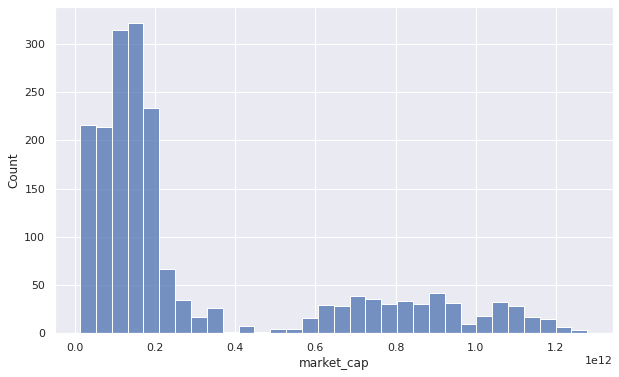

In [200]:
sns.histplot(x='market_cap', data=df);


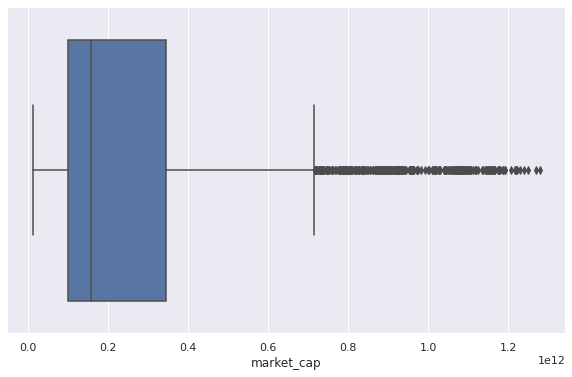

In [202]:
sns.boxplot(x=df['market_cap'])


In [204]:
#np.where(df['market_cap']>0.4e12)

(array([   9,   12,   24,   29,   39,   48,   51,   52,   69,   76,   78,
         105,  110,  121,  129,  134,  136,  161,  164,  172,  177,  182,
         195,  197,  202,  209,  211,  221,  223,  226,  232,  238,  249,
         250,  260,  264,  290,  293,  314,  316,  318,  351,  367,  371,
         378,  383,  384,  385,  406,  410,  426,  428,  429,  431,  441,
         447,  451,  455,  458,  477,  478,  485,  488,  495,  502,  504,
         508,  512,  522,  529,  553,  555,  563,  568,  572,  573,  574,
         575,  576,  586,  587,  593,  595,  598,  605,  624,  637,  644,
         645,  652,  655,  666,  670,  671,  673,  676,  683,  688,  704,
         706,  709,  718,  723,  728,  732,  734,  736,  740,  751,  753,
         765,  766,  770,  796,  799,  802,  833,  847,  852,  855,  856,
         858,  860,  861,  862,  863,  865,  868,  869,  874,  876,  877,
         882,  884,  886,  888,  889,  891,  892,  893,  894,  895,  896,
         897,  898,  899,  900,  901, 

In [131]:
print(f"{m_}Average total_volume: {df[~df.total_volume.isnull()].total_volume.mean():.1f}")


Average total_volume: 20587505254.9


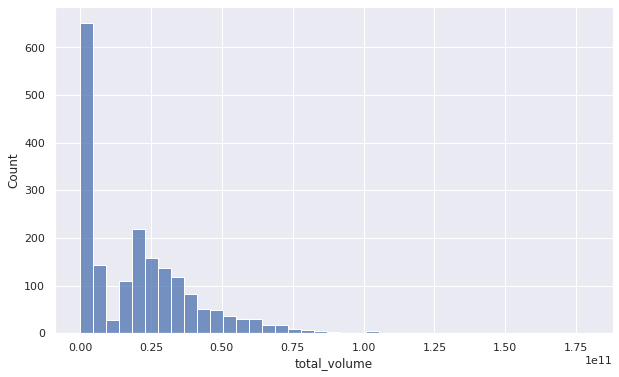

In [132]:
sns.histplot(x='total_volume', data=df);


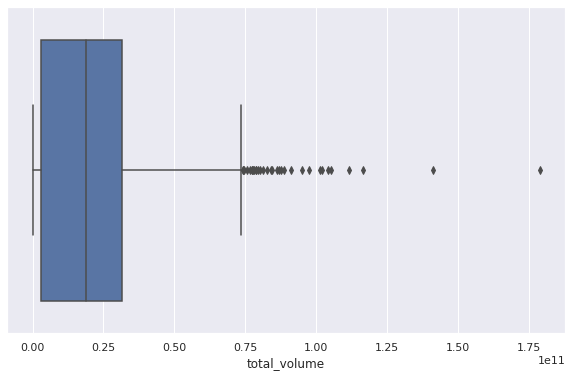

In [116]:
sns.boxplot(x=df['total_volume'])


In [133]:
print(f"{m_}Average alexa_rank: {df[~df.alexa_rank.isnull()].alexa_rank.mean():.1f}")


Average alexa_rank: 9722.0


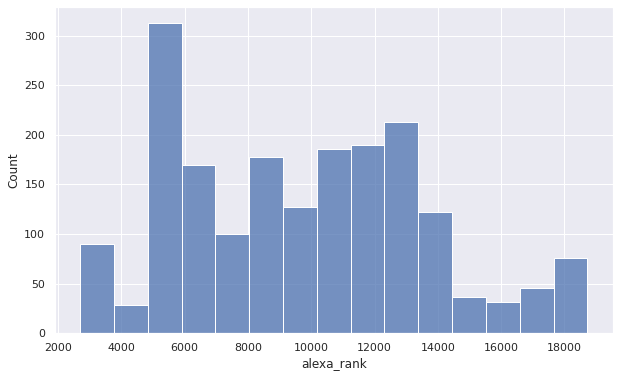

In [134]:
sns.histplot(x='alexa_rank', data=df);


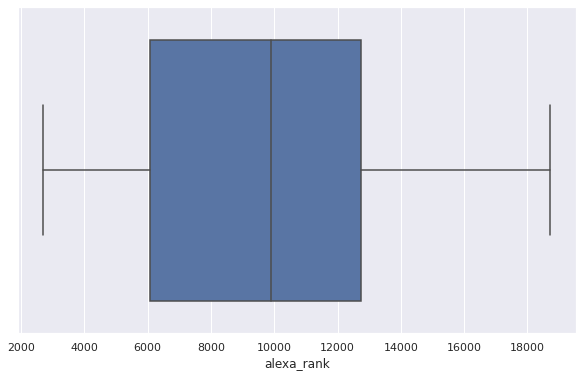

In [135]:
sns.boxplot(x=df['alexa_rank'])


In [183]:
print(f"{m_}Average pull_request_contributors: {df[~df.pull_request_contributors.isnull()].pull_request_contributors.mean():.1f}")


Average pull_request_contributors: 584.1


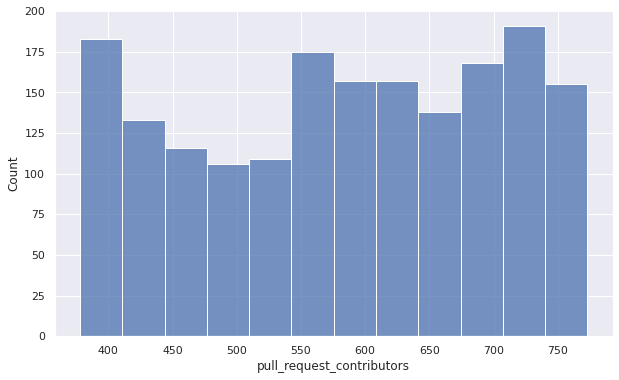

In [184]:
sns.histplot(x='pull_request_contributors', data=df);


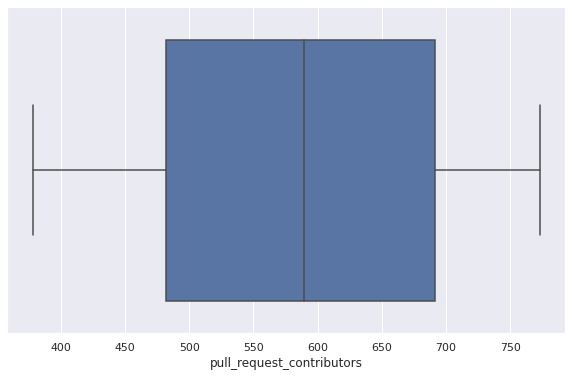

In [185]:
sns.boxplot(x=df['pull_request_contributors'])


In [139]:
print(f"{m_}Average commit_count_4_weeks: {df[~df.commit_count_4_weeks.isnull()].commit_count_4_weeks.mean():.1f}")


Average commit_count_4_weeks: 259.5


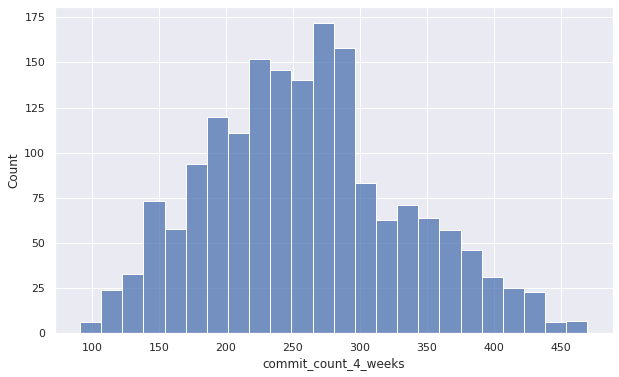

In [121]:
sns.histplot(x='commit_count_4_weeks', data=df);


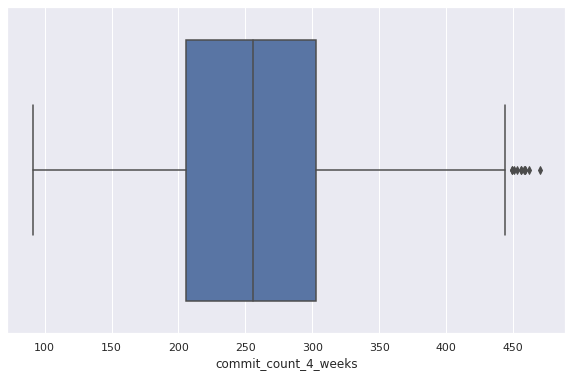

In [122]:
sns.boxplot(x=df['commit_count_4_weeks'])


In [140]:
print(f"{m_}Average pull_requests_merged: {df[~df.pull_requests_merged.isnull()].pull_requests_merged.mean():.1f}")


Average pull_requests_merged: 6645.3


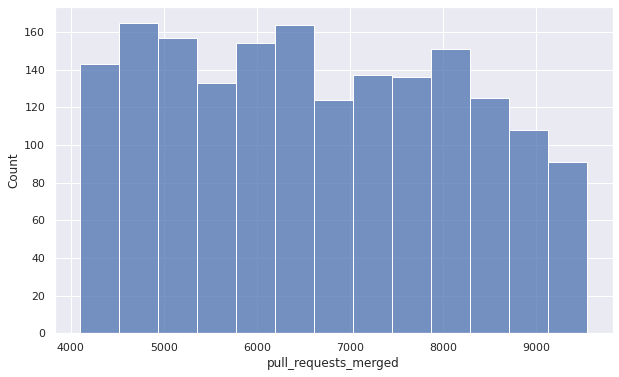

In [123]:
sns.histplot(x='pull_requests_merged', data=df);


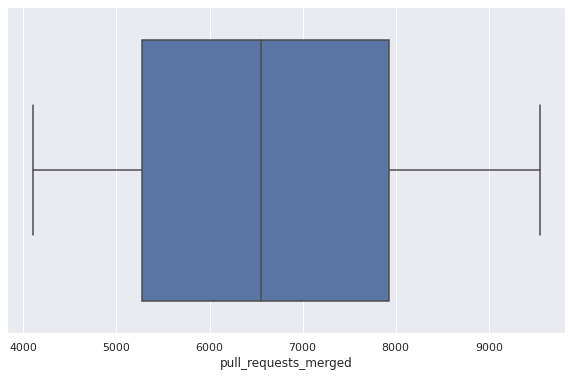

In [124]:
sns.boxplot(x=df['pull_requests_merged'])


In [142]:
print(f"{m_}Average clossed_issues: {df[~df.closed_issues.isnull()].closed_issues.mean():.1f}")


Average clossed_issues: 3524.3


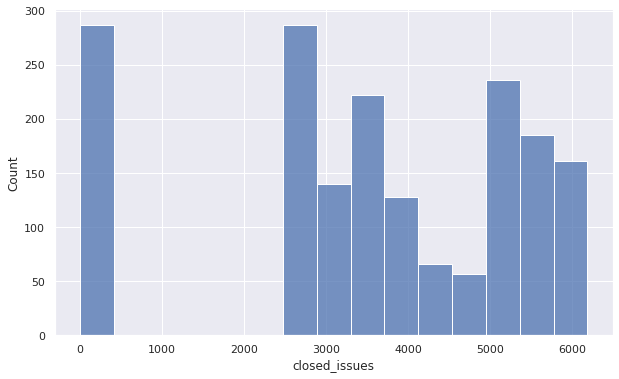

In [125]:
sns.histplot(x='closed_issues', data=df);


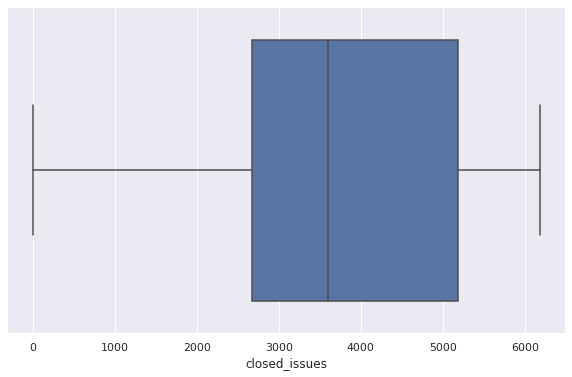

In [126]:
sns.boxplot(x=df['closed_issues'])


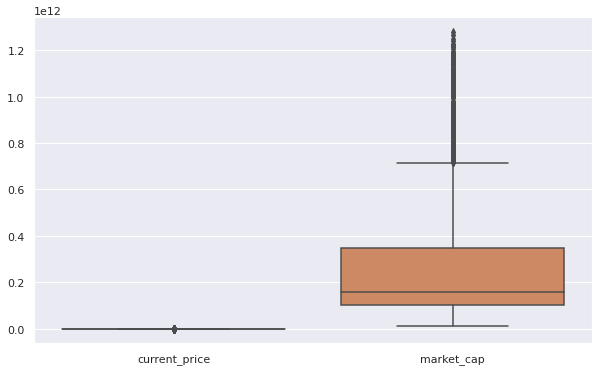

In [15]:
#sns.boxplot(data=df[['current_price', 'market_cap']])
#plt.show()

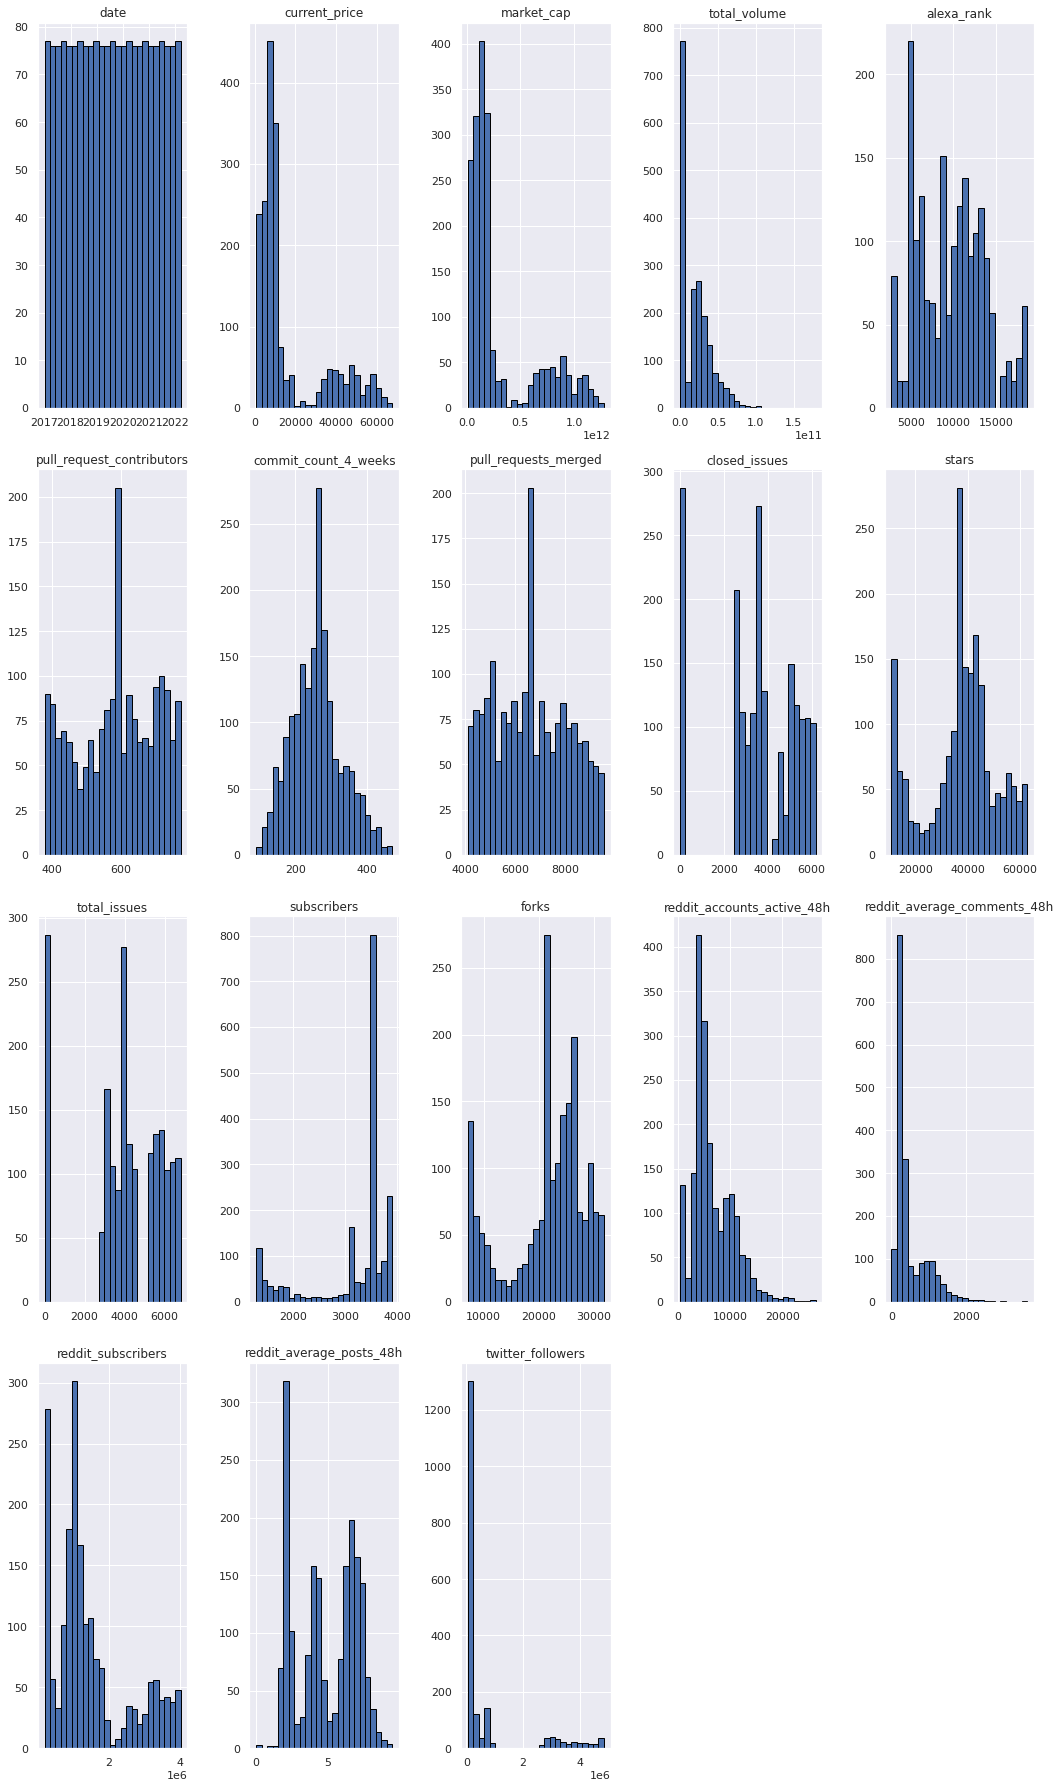

In [242]:
# Plots the histogram for each numerical feature in a separate subplot
df.hist(bins=25, figsize=(15, 25), layout=(-1, 5), edgecolor="black")
plt.tight_layout();

Correlation analysis measures the statistical relationship between two different variables. The result will show how the change in one parameter would impact the other parameter.

### Feature correlation. 

Spearman correlation evaluates the monotonic relationship based on the ranked values for each feature
.

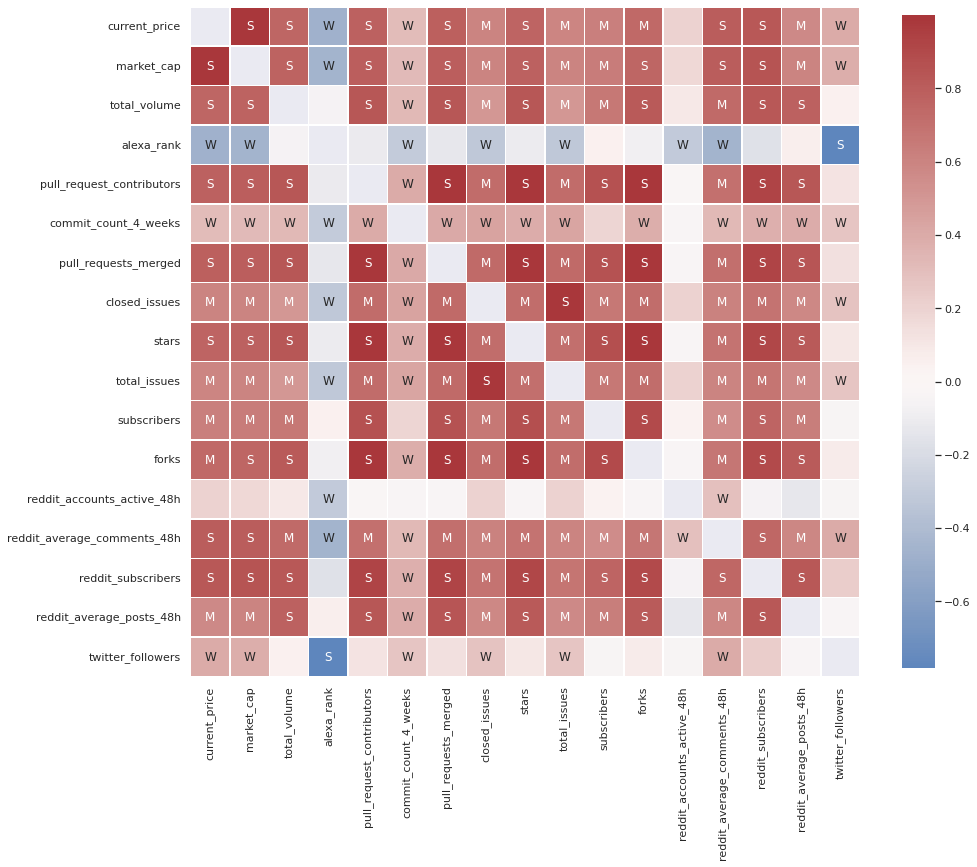

In [243]:
df_corr = df.corr(method="spearman")

# Create labels for the correlation matrix
labels = np.where(np.abs(df_corr)>0.75, "S",
                  np.where(np.abs(df_corr)>0.5, "M",
                           np.where(np.abs(df_corr)>0.25, "W", "")))

# Plot correlation matrix
plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, mask=np.eye(len(df_corr)), square=True,
            center=0, annot=labels, fmt='', linewidths=.5,
            cmap="vlag", cbar_kws={"shrink": 0.8});